In [1]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

In [2]:
import opendatasets as od
import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/andrewmvd/medical-mnist'
od.download(dataset_url)
data_dir = '/content/medical-mnist'

def load_images_from_directory(directory):
    images, labels = [], []

    # Load images from each folder named by class label
    for class_label in os.listdir(directory):
        class_path = os.path.join(directory, class_label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith(".jpeg"):
                    image_path = os.path.join(class_path, file)

                    # Load and preprocess the image
                    image = cv2.imread(image_path)
                    if image is not None:
                        image = cv2.resize(image, (32, 32))
                        image = img_to_array(image)
                        images.append(image)

                        # Use the folder name as the label
                        labels.append(class_label)

    # Convert to numpy arrays and normalize the images
    return np.array(images, dtype="float") / 255.0, np.array(labels)

# Load all images and labels
images, labels = load_images_from_directory(data_dir)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# Binarize the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Check data loading and verify classes
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')
print("Classes:", lb.classes_)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: harz01
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/medical-mnist


100%|██████████| 84.8M/84.8M [00:05<00:00, 16.4MB/s]



Training samples: 47163, Testing samples: 11791
Classes: ['AbdomenCT' 'BreastMRI' 'CXR' 'ChestCT' 'Hand' 'HeadCT']


In [4]:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.models import Model

def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = AveragePooling2D((2, 2))(x)

    # Second block
    x = Conv2D(128, (5, 5), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Third block
    x = Conv2D(256, (3, 3), activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First block
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Second block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


input_shape = (32, 32, 3)  # Updated input shape
num_classes = len(lb.classes_)


In [5]:
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=4, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

Epoch 1/4
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9730 - loss: 0.1006 - val_accuracy: 0.9979 - val_loss: 0.0086 - learning_rate: 0.0100
Epoch 2/4
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9992 - val_loss: 0.0039 - learning_rate: 0.0100
Epoch 3/4
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9989 - val_loss: 0.0037 - learning_rate: 0.0100
Epoch 4/4
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9965 - val_loss: 0.0115 - learning_rate: 0.0100
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [6]:


def distillation_loss(y_true, y_pred, teacher_preds, temperature=5.0, alpha=0.3):
    # Adjust temperature for teacher and student predictions
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)

    # Compute KL divergence for soft loss
    soft_loss = tf.keras.losses.KLDivergence()(teacher_batch_preds_soft, y_pred_soft)

    # Compute categorical cross-entropy for hard loss
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Weighted combination of soft and hard losses
    return alpha * soft_loss + (1. - alpha) * hard_loss


In [7]:
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

Teacher test accuracy: 99.65%


In [8]:
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
student.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

Epoch 1/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9767 - loss: 0.0736 - val_accuracy: 0.9980 - val_loss: 0.0183 - learning_rate: 0.0010
Epoch 2/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9968 - loss: 0.0174 - val_accuracy: 0.9976 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 3/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9979 - loss: 0.0118 - val_accuracy: 0.9973 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 4/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9981 - loss: 0.0105 - val_accuracy: 0.9990 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 5/5
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9977 - loss: 0.0114 - val_accuracy: 0.9986 - val_loss: 0.0125 - learning_rate: 0.0010


In [9]:
# Evaluate models
#teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
#print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

Student test accuracy: 99.86%


In [10]:
# Evaluate the teacher model
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)

print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Generate predictions from the teacher model
teacher_preds_probs = teacher.predict(x_test)
teacher_preds = np.argmax(teacher_preds_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print the classification report for the teacher model
print("=== Teacher Model Classification Report ===")
print(classification_report(y_true, teacher_preds, target_names=lb.classes_))

Teacher test accuracy: 99.65%
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== Teacher Model Classification Report ===
              precision    recall  f1-score   support

   AbdomenCT       1.00      0.98      0.99      2000
   BreastMRI       1.00      1.00      1.00      1791
         CXR       1.00      1.00      1.00      2000
     ChestCT       0.98      1.00      0.99      2000
        Hand       1.00      1.00      1.00      2000
      HeadCT       1.00      1.00      1.00      2000

    accuracy                           1.00     11791
   macro avg       1.00      1.00      1.00     11791
weighted avg       1.00      1.00      1.00     11791



In [11]:
alpha_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
temperature_values = [1.0, 2.0, 5.0, 10.0]  # Adjust temperature values as needed

results = []  # To store results for each combination of alpha and temperature

teacher_preds = teacher.predict(x_train)

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given alpha and temperature
def evaluate_student(alpha, temperature):
    def distillation_loss(y_true, y_pred, teacher_preds, temperature=temperature, alpha=alpha):
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)

        soft_loss = tf.keras.losses.KLDivergence()(teacher_batch_preds_soft, y_pred_soft)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        return alpha * soft_loss + (1. - alpha) * hard_loss

    student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
                    metrics=['accuracy'])

    student.fit(x_train, y_train, batch_size=32, epochs=8, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store the results in the dictionary
    results.append({
        "alpha": alpha,
        "temperature": temperature,
        "f1_score": f1,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "inference_time": inference_time
    })

    print(f"=== Alpha: {alpha}, Temperature: {temperature} ===")
    print(f"F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"Inference Time: {inference_time:.4f} seconds\n")

# Run evaluation for each combination of alpha and temperature
for alpha in alpha_values:
    for temperature in temperature_values:
        evaluate_student(alpha, temperature)

1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=== Alpha: 0.0, Temperature: 1.0 ===
F1 Score: 0.9991, Accuracy: 0.9991, Precision: 0.9991, Recall: 0.9991
Inference Time: 2.9439 seconds

369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=== Alpha: 0.0, Temperature: 2.0 ===
F1 Score: 0.9995, Accuracy: 0.9995, Precision: 0.9995, Recall: 0.9995
Inference Time: 1.6669 seconds

369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=== Alpha: 0.0, Temperature: 5.0 ===
F1 Score: 0.9992, Accuracy: 0.9992, Precision: 0.9992, Recall: 0.9992
Inference Time: 1.7557 seconds

369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=== Alpha: 0.0, Temperature: 10.0 ===
F1 Score: 0.9993, Accuracy: 0.9993, Precision: 0.9993, Recall: 0.9993
Inference Time: 1.5133 seconds

369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== Alpha: 0.1, Temperature: 1.0 ===
F1 Score: 0.9987, Accuracy: 0.9987, Precision: 0.9987, Recall: 0.9987
Inference Time: 2.9579 seconds

369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=== Alpha: 0.1,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Alpha: 1.0, Temperature: 2.0 ===
F1 Score: 0.1569, Accuracy: 0.2945, Precision: 0.1125, Recall: 0.2945
Inference Time: 1.6791 seconds

369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Alpha: 1.0, Temperature: 5.0 ===
F1 Score: 0.0576, Accuracy: 0.1698, Precision: 0.0348, Recall: 0.1698
Inference Time: 2.9544 seconds

369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
=== Alpha: 1.0, Temperature: 10.0 ===
F1 Score: 0.0531, Accuracy: 0.1699, Precision: 0.0318, Recall: 0.1699
Inference Time: 1.5495 seconds



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


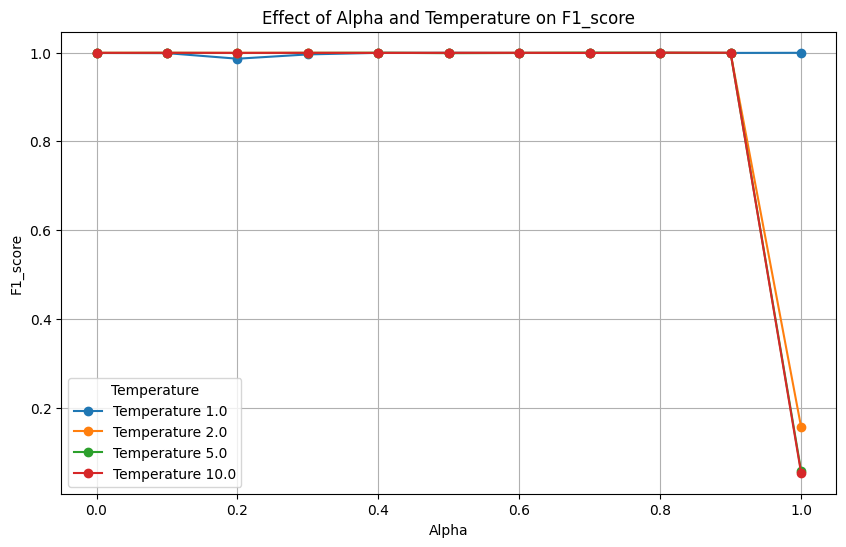

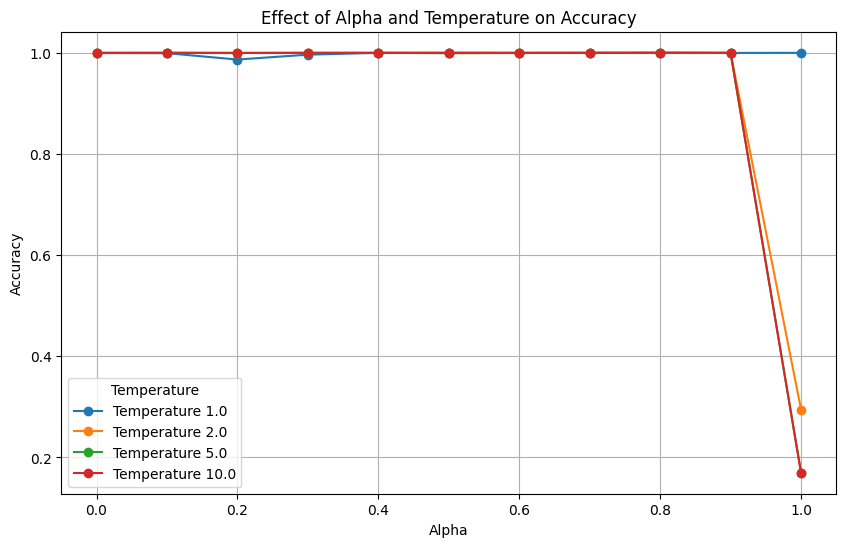

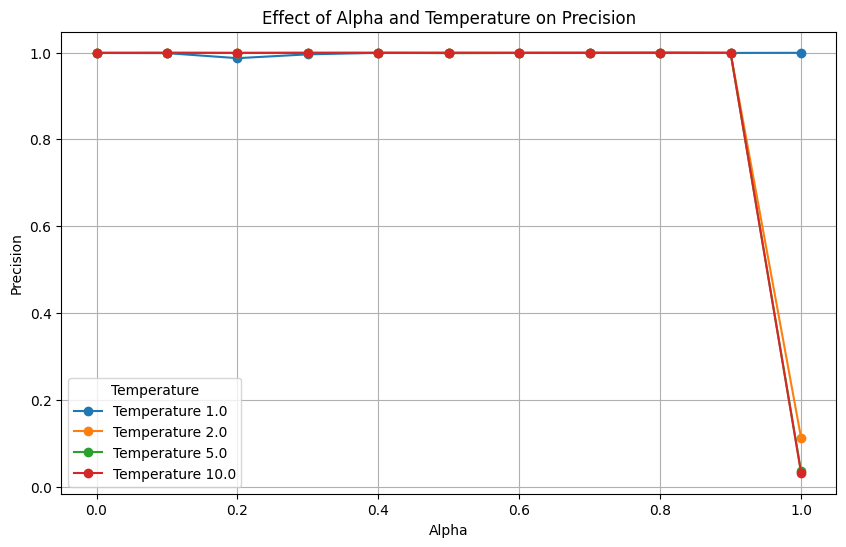

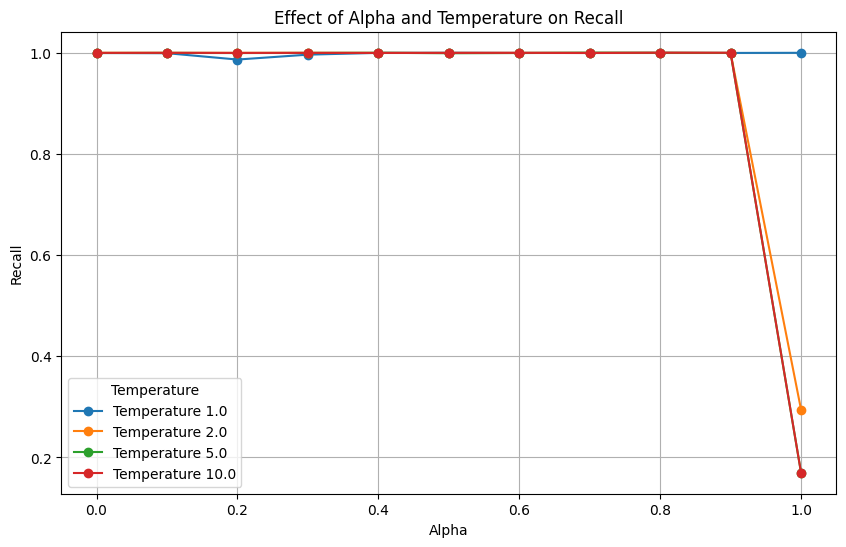

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Example results data (replace this with your actual results)
# results = [
#     {"alpha": 0.0, "temperature": 1.0, "f1_score": 0.75, "accuracy": 0.8, "precision": 0.78, "recall": 0.76, "inference_time": 0.05},
#     {"alpha": 0.1, "temperature": 1.0, "f1_score": 0.76, "accuracy": 0.81, "precision": 0.79, "recall": 0.77, "inference_time": 0.06},
#     ...
# ]

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Create subplots for each metric
metrics = ['f1_score', 'accuracy', 'precision', 'recall']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for temp in results_df['temperature'].unique():
        subset = results_df[results_df['temperature'] == temp]
        plt.plot(subset['alpha'], subset[metric], marker='o', label=f'Temperature {temp}')

    plt.title(f'Effect of Alpha and Temperature on {metric.capitalize()}')
    plt.xlabel('Alpha')
    plt.ylabel(metric.capitalize())
    plt.legend(title="Temperature")
    plt.grid(True)
    plt.show()
